In [1]:
%matplotlib inline

import numpy as np
#import mplcyberpunk
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons

plt.style.use("fivethirtyeight")

rcParams["font.sans-serif"] = "Roboto"
rcParams["xtick.labelsize"] = 14.
rcParams["ytick.labelsize"] = 14.
rcParams["axes.labelsize"] = 14.
rcParams["legend.fontsize"] = 14
rcParams["axes.titlesize"] = 16.

np.random.seed(42)

_ = torch.manual_seed(42)

# Introduction to PyTorch

In this notebook, we're going to be taking the core ideas from the first notebook, and abstracting all of the computation away using the relatively high-level interface by PyTorch. 

I highly recommend using the PyTorch documentation as a reference, in particular [the page on the `torch.nn` module](https://pytorch.org/docs/stable/nn.html) is where I frequently go back to, as it provides instructions (and equations) on relevant implementations in PyTorch. When in doubt, you can also go one layer deeper into the problem, and start looking into the source code.

## A Guide to the PyTorch Interface

Before we dive into any coding, we should assess how PyTorch as an API is laid out, so you will know where to look for things as you need to. There's also a level of underlying design choices to consider, so that when it comes to routine model building we can take advantage of PyTorch _and_ Python as languages as much as possible. As eluded to in the first notebook, PyTorch is very much an object-oriented and [Pythonic](https://www.python.org/dev/peps/pep-0020/) library, and so there's a strong emphasis on not needing to repeat code by taking advantage of things like inheritance. For the most part, building models in PyTorch is essentially building classes in Python—all of the standard neural network layers are built off the same class, and so will your own models/layers. This substantially reduces the need for a lot of different boiler plate codes, for example when you come to implement training loops.

For most purposes, the `torch.nn` module provides access to high-level, object-oriented implementations of standard neural network building blocks, including your standard fully-connected layer (`nn.Linear`), convolution layers (e.g. `nn.Conv1d`), and recurrent layers (e.g. `nn.LSTMCell`). All of these objects inherit from the `nn.Module` base class, and abstracts away a lot of concepts like nesting multiple layers, saving and loading models, moving your code onto GPUs, and hopping between training and evaluation phases. The `torch.nn` module also provides access to other neural network tools, such as standard activation functions and losses (see notebook 2)—these also inherit from `nn.Module`. 

While `torch.nn` modules give you access to objects that represent the building blocks, when it comes to computation they actually just call routines in their functional `torch.nn.functional` interface; for example, `nn.ReLU()` creates an object that, at runtime, calls `torch.nn.functional.relu()` on your inputs. In principle, you could build entire models using only the functional interface, but because you're giving up the benefits of class inheritance, you will have to write a lot of boiler plate code. An intermediate solution is to write a mixture of `torch.nn` and `torch.nn.functional` calls, but if you want the code to be simple and unified you should keep this to a minimum and use the recommended object-oriented interface. To go down yet another layer, `torch.nn.functional` ends up using low-level C/C++/CUDA routines, including those from Caffe2. The other submodule of `torch` you will frequently access is `torch.optim`, which provides access to various optimization algorithms. Each implemented optimizer inherits from `torch.optim.BaseOptimizer`, which has a very similar implementation to `torch.nn.Module`.

Finally, at the top level of `torch` are standard math functions and random number generation. So for the most part, this is a drop and replace of NumPy routines, like `torch.exp` and `torch.rand`. One key difference between the two interfaces is the keyword argument `axis` in NumPy is actually `dim` in PyTorch. So when performing operations on nominally the type of array, you will have to swap the kwargs.

---

## `torch.Tensor` — the Heart of PyTorch

The `torch.Tensor` is at the core of everything to do with PyTorch.

In [2]:
X = torch.Tensor([0.])

Tensors more or less behave like `numpy.ndarray`, doing all the fancy broadcasting and vectorization stuff. There's two big differences with `torch.Tensor`, however, that make it the true centerpiece of PyTorch:

1. You can move it onto your GPU

In [3]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    X.to("cuda")

which it will then subsequently do all its computation on your GPU. This is an easy way to do extremely scalable calculations with minimal change in the way that you code (if you can't write CUDA, for example). The other big difference is:

2. Automatic differentiation

This is definitely more of a general PyTorch thing, but the support for autograd in PyTorch is amazing. The idea is you can perform any combination of computations you want, and you can simply backpropagate through all your calculations to compute the gradient with respect to your tensor. For example:

In [4]:
# Create a PyTorch Variable from a tensor, and ask it to track gradients
X = torch.autograd.Variable(torch.Tensor([10.]), requires_grad=True)

# Do some computation
Y = 20. + X
# Do some probabilistic computation
Y *= torch.rand(1)
Y = torch.sin(Y)

In [5]:
# if you inspect X, it shows that you've specified gradients
print(f"Tensor X: {X}")
print(f"Tensor Y: {Y}")

Tensor X: tensor([10.], requires_grad=True)
Tensor Y: tensor([0.9724], grad_fn=<SinBackward>)


In [6]:
# Compute gradients
Y.backward()

In [7]:
# Calculate the dY/dX
X.grad

tensor([0.2058])

The important thing about this easy access to auto differentiation is for all of our neural network building: because we work with tensors, all of which support this feature, we can perform backpropagation for training without even needing to think about the problem as it does a bunch of chain rule computations in the background. In general, this is also a nifty feature because it means if you ever need to compute derivatives of complicated functions, you know you can do it numerically with PyTorch quite easily.

Instead of calling `Y.backward()`, you can also access the automatic differentiation interface with the `torch.autograd` module. This gives you some freedom to perform the computation, say if you wanted to take partial derivatives with respect to specific variables.

In [8]:
A = torch.autograd.Variable(torch.Tensor([3.]), requires_grad=True)
B = torch.autograd.Variable(torch.Tensor([23.]), requires_grad=True)

C = (A * B) / (A + B)
C = torch.sigmoid(C)

print(f"Tensor C: {C}")

Tensor C: tensor([0.9342], grad_fn=<SigmoidBackward>)


In [9]:
# Take derivative of C with respect to B
torch.autograd.backward([C], [B])

In [10]:
# dC/dB
B.grad

tensor([0.0188])

If you want to do the same computation for `A`, you'll have to ask it to `retain_graphs=True`: by default once autograd is done, the computational graph used for the chain of calculations is freed up.

## Building a PyTorch model

We now have all the ingredients necessary to start doing deep learning with PyTorch. As mentioned previously, everything is built using pieces that work with `torch.Tensor` objects and `torch.nn.Module` objects. But in addition to these, PyTorch also provides convenience classes for working with datasets, including such features as minibatching and random test/validation splitting.

To start, we will create a [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class that provides an interface for accessing data from our moon samples. Subclasses of the `Dataset` class must implement a `__len__()` function that returns the total number of data points in the dataset and a `__getitem__(idx)` function that returns one data point (in the form of a tensor) and its target value (label), also in the form of a tensor.

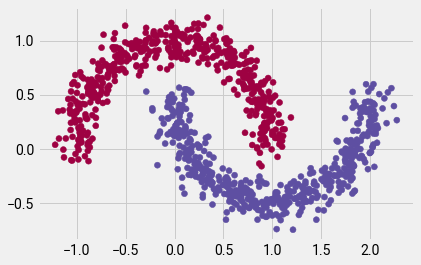

In [11]:
class MoonData(Dataset):
    def __init__(self, n_samples : int, noise : float):
        self.n_samples = n_samples
        self.noise = noise
        
        self.data, self.labels = make_moons(n_samples=self.n_samples,noise=self.noise)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        #since self.labels[idx]  returns a single number, need to enclose it in a list when creating the tensor
        return torch.Tensor(self.data[idx]), torch.Tensor([self.labels[idx]])
    
train_data = MoonData(1000,0.1)
test_data = MoonData(200,0.1)

fig, ax = plt.subplots()
ax.scatter(train_data.data[:,0], train_data.data[:,1], c=train_data.labels, cmap="Spectral")

Here we've created 2 `MoonData` datasets: one that will be used for training the model, and another that will be used for testing the performance of the model. This is a standard and important practice in machine learning. The idea is to ensure that the model isn't "overfitting" the training data and memorizing exactly how to reproduce the examples it's seen. We want the model to also be able to provide meaningful predictions for data that it hasn't previously seen. If the model performs well (has a low loss) for the training data, but performs poorly for the test/validation data, then it is likely that the model is either overtrained or requires additional [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)).

PyTorch also provides a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class that is designed to work with `Dataset` objects. The `DataLoader` class supports minibatching and randomizing the order of samples drawn from the set. In particular, minibatching is a widely used method for training models: instead of computing the loss for the entire dataset and updating the model, a "mini-batch" of samples is drawn from the dataset and the model is updated based only on those samples. The process is repeated until all/most samples have been used, and this comprises one training "epoch." This algorithm is beneficial both from a computational standpoint (it allows for speedups in the underlying calculations by using parallel algorithms without requiring excessive memory use) and from a practical standpoint: the model is less likely to get stuck in a local minimum of the loss function. Because of the computational efficiency, mini-batching is also often used for computing validation losses as well.

Here we create one DataLoader object for our test data, and another for our validation data.

In [12]:
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)

With the data in place, we can create a classifier model for the Moon Data. As mentioned before, PyTorch is written such that its models/layers are reusable: each inherits from `torch.nn.Module` so that it can be reused and is interoperable. At its simplest, a `torch.nn.Module` object needs to implement a `forward` function that takes an input tensor `X` and performs a forward pass of the calculation. This may involve one or more layers of calculations, activations, transformations, or other operations. Any calculations should be performed using `torch` functions so that gradients can later be passed through the network by backpropagation.

There are many, many ways to build models with PyTorch. Here we will show one strategy that makes use of `torch.nn.Sequential`, which is a convenience class that stores a series of [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) objects that will be called in sequence. We will simply use a sequence of linear layers followed by activation functions. Since our input MoonData has 2 features, the first linear layer must have an input size of 2. The [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) class is an implementation of a fully-connected linear layer like we've used before: it takes the number of input features and the number of output features as arguments to its constructor (along with an optional `bias` parameter that controls whether or not to include bias parameters-- the default is True). Internally, the object will initialize all of the parameters needed for the linear layer calculation. We don't have to keep track of those ourselves! Of course, PyTorch does provide mechanisms for allowing you to access/initialize the parameters manually if you need to do so.

After each linear layer, we will include an activation layer. Many standard types are [available](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) as `torch.nn.Module` objects for convenience, and they are also available through PyTorch's [functional interface](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions) if you wish to use them as functions directly instead of as modules. Just to illustrate, we'll use ReLU and Tanh along the way.

Our goal with the MoonClassifier is to determine which moon distribution a given datapoint comes from. There are 2 categories, which are  represented as 0 and 1. Therefore, for every input, we want to produce 1 number that ideally is 0 or 1. As we saw previously, the sigmoid activation function is useful for this purpose. Our final layer will have an output size of 1, and we will run it through a sigmoid layer to compress that number into the range \[0,1\].

In [13]:
class MoonClassifier(nn.Module):
    def __init__(self):
        super(MoonClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,20),
            nn.ReLU(),
            nn.Linear(20,5),
            nn.Tanh(),
            nn.Linear(5,1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        X = self.layers(X)
        return X

In the code above, we initialize the `torch.nn.Module` superclass and create a `torch.nn.Sequential` module that contains the calculations we wish to perform. Inside the `forward` call, we simply pass the input `X` to this `self.layers` object, which in turn will perform a forward calculation through the sequence of layers we defined before. As we saw in the first notebook, PyTorch modules all come with a predefined `__call__` function which invokes the `forward` function when the module itself is called like a function. 

With our completely untrained model, we can pass data through it and see what it outputs.

In [14]:
model = MoonClassifier()
X,y = train_data[0]
model(X)

tensor([0.4494], grad_fn=<SigmoidBackward>)

When using the `Dataset` classes, PyTorch will automatically concatenate samples along the appropriate axis so that the model can evaluate many samples in a single pass using broadcasting. Here we select 10 samples and show that we can run them though the model the same way.

In [15]:
X,y = train_data[0:10]
print(model(X),y)

tensor([[0.4494],
        [0.4464],
        [0.4461],
        [0.4512],
        [0.4548],
        [0.4476],
        [0.4500],
        [0.4493],
        [0.4451],
        [0.4427]], grad_fn=<SigmoidBackward>) tensor([[1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]])


Now we need to train the model, which requires the use of a loss function (e.g., mean squared error) and an optimization strategy (e.g., gradient descent). PyTorch provides a variety of optimizers in the [`torch.optim`](https://pytorch.org/docs/stable/optim.html) module. The key idea is that the optimizer operates on the model's parameters, each of which has a gradient that PyTorch can calculate. The workflow is:
1. Calculate the output from the model
2. Use the model output and the target values to compute the loss (which is a `torch.Tensor`)
3. Zero out the gradients of the model parameters.
4. Compute the gradients of the loss tensor by back-propagation. Since they depend on the model parameters, the model parameter tensors' gradients will be updated.
5. Use the optimizer to update the model parameters by performing some kind of calculation with the parameters and their gradients. In PyTorch, this is done by the `optimizer.step` function.

In the code below, we define a training loop that will perform a training cycle over a single epoch: it will loop over all minibatches in the dataset, and for each mini-batch, it will follow the workflow above. In addition, it keeps track of the total loss for the entire dataset, which in the end is normalized by dividing by the number of samples.

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_total = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print some output every 5 batches
        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_total += loss
            
    print(f"Training epoch complete! Loss = {loss_total/size:>7f}")
    return loss_total/size
        

Our code also needs to compute the validation loss, which is done in the `test_loop` function below. Here it keeps track of the total loss and the number of correct predictions from the model, which we'll use to calculate the model's accuracy. Here we loop over the data in the minibatch as when we trained, but this time we don't do anything with an optimizer: we just calculate the loss and the number of correct guesses. In the code below, we consider a guess to be correct if it rounds to the correct number (or if the absolute value of the difference between the prediction and the true label is less than 0.5).

In [17]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() #item returns the number from a Torch tensor containing a single value
            
            #since X is a minibatch, pred and y are tensors with several elements.
            #Add up to get the number of correct predictions in this minibatch
            correct += (torch.abs(pred-y) < 0.5).type(torch.float).sum().item()

    #normalize the loss for size, and convert correct to a fraction
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

Finally, we'll wrap these two functions into a single function that performs a training run and a test run for a given number of epochs, then plots the training loss and accuracy as a function of epoch.

In [18]:
def train_and_test(model,epochs,train_loader,test_loader,loss_fn,optimizer):
    epoch = []
    loss = []
    acc = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        l = train_loop(train_loader, model, loss_fn, optimizer)
        a = test_loop(test_loader, model, loss_fn)
        epoch.append(t+1)
        loss.append(l)
        acc.append(a)
        
    print("Done!")
    
    fig,axes = plt.subplots(1,2,figsize=(10,4))
    axes[0].plot(epoch,loss,label="Training loss")
    axes[0].set_ylabel("Training loss")
    axes[0].set_xlabel("Epoch")
    axes[1].plot(epoch,acc,label="Testing accuracy")
    axes[1].set_ylabel("Testing accuracy")
    axes[1].set_xlabel("Epoch")
    fig.tight_layout()

Now all we need to do is define our loss function and optimizer. We'll use PyTorch's standard implementation of Mean Squared Error loss and its stochastic gradient descent optimizer. There are many [optimizers available](https://pytorch.org/docs/stable/optim.html#algorithms), but they all require as a first argument a list of model parameters. As long as our model is a `torch.nn.Module`, we can access its parameters easily with the `parameters()` function. Each algorithm may also take other optional arguments, which are model hyperparameters. Here we set the learning rate of the gradient descent algorithm to 0.3.


Epoch 1
-------------------------------
loss: 0.242884  [    0/ 1000]
loss: 0.244830  [  100/ 1000]
loss: 0.246968  [  200/ 1000]
loss: 0.235755  [  300/ 1000]
loss: 0.228569  [  400/ 1000]
loss: 0.227077  [  500/ 1000]
loss: 0.217473  [  600/ 1000]
loss: 0.244995  [  700/ 1000]
loss: 0.196884  [  800/ 1000]
loss: 0.199028  [  900/ 1000]
Training epoch complete! Loss = 0.002284
Test Error: 
 Accuracy: 75.5%, Avg loss: 0.009672 

Epoch 2
-------------------------------
loss: 0.206667  [    0/ 1000]
loss: 0.164557  [  100/ 1000]
loss: 0.142137  [  200/ 1000]
loss: 0.150211  [  300/ 1000]
loss: 0.119675  [  400/ 1000]
loss: 0.185010  [  500/ 1000]
loss: 0.120876  [  600/ 1000]
loss: 0.156733  [  700/ 1000]
loss: 0.101936  [  800/ 1000]
loss: 0.100491  [  900/ 1000]
Training epoch complete! Loss = 0.001448
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.005248 

Epoch 3
-------------------------------
loss: 0.098406  [    0/ 1000]
loss: 0.085497  [  100/ 1000]
loss: 0.053733  [  200/ 1000]
loss

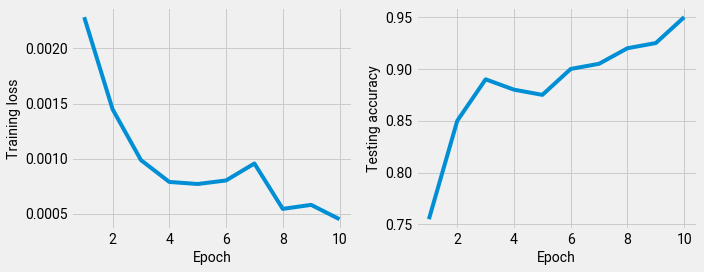

In [19]:
loss_fn = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.3) #lr is learning rate
train_and_test(model,10,train_dataloader,test_dataloader,loss_fn,optimizer)

Now we can visualize the results of the model. We'll run the entire test set through the model (`test_data[:][0]` returns the `X` tensor for the entire test data set), then visualize the results, color coding by the model's prediction. Note the use of `with torch.no_grad()`: this context manager will disable gradients on all `torch.Tensor` objects. Anytime you are not training the model, gradients are unnecessary, and retaining them slows down the calculations.

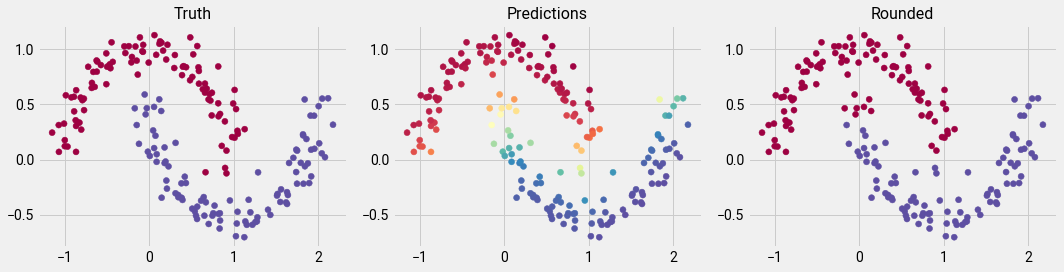

In [20]:
with torch.no_grad():
    pred = model(test_data[:][0])
    
fig,axes = plt.subplots(1,3,figsize=(15,4))

axes[0].scatter(test_data.data[:,0],test_data.data[:,1],c=test_data.labels,cmap="Spectral")
axes[0].set_title("Truth")
axes[1].scatter(test_data.data[:,0],test_data.data[:,1],c=pred,cmap="Spectral")
axes[1].set_title("Predictions")
axes[2].scatter(test_data.data[:,0],test_data.data[:,1],c=pred.round(),cmap="Spectral")
axes[2].set_title("Rounded")
fig.tight_layout()

With these pieces in place, it is pretty easy to modify the model, assess its performance, and retry new architectures. The code below shows a new version of the MoonClassifier with the Tanh activation layer replaced by ReLU. You can make other modifications as well. It is possible to define your own layers and combine them into a model, add normalization, dropout, pooling, or other features, and so on. The pytorch interface is very flexible and allows you to mix and match pieces in nearly any way you want.

In [21]:
class MoonClassifierV2(nn.Module):
    def __init__(self):
        super(MoonClassifierV2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,20),
            nn.ReLU(),
            nn.Linear(20,5),
            nn.ReLU(),
            nn.Linear(5,1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        X = self.layers(X)
        return X

Since the optimizer and loss function are defined independently of the model, it is very easy to change either of these if you wish. Here they are kept the same as before, and we can see that this code snippet can be used to quickly train and test a new model with our desired optimization strategy.

Epoch 1
-------------------------------
loss: 0.254484  [    0/ 1000]
loss: 0.253986  [  100/ 1000]
loss: 0.251023  [  200/ 1000]
loss: 0.249567  [  300/ 1000]
loss: 0.249495  [  400/ 1000]
loss: 0.249089  [  500/ 1000]
loss: 0.249493  [  600/ 1000]
loss: 0.247680  [  700/ 1000]
loss: 0.247805  [  800/ 1000]
loss: 0.248555  [  900/ 1000]
Training epoch complete! Loss = 0.002501
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.012463 

Epoch 2
-------------------------------
loss: 0.241928  [    0/ 1000]
loss: 0.249150  [  100/ 1000]
loss: 0.248670  [  200/ 1000]
loss: 0.250310  [  300/ 1000]
loss: 0.251374  [  400/ 1000]
loss: 0.248998  [  500/ 1000]
loss: 0.248089  [  600/ 1000]
loss: 0.246056  [  700/ 1000]
loss: 0.244382  [  800/ 1000]
loss: 0.246911  [  900/ 1000]
Training epoch complete! Loss = 0.002476
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.012119 

Epoch 3
-------------------------------
loss: 0.246058  [    0/ 1000]
loss: 0.237894  [  100/ 1000]
loss: 0.240055  [  200/ 1000]
loss

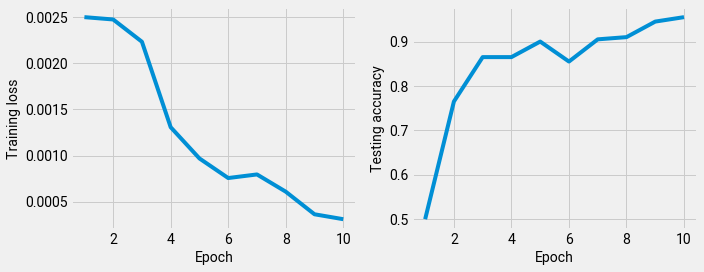

In [22]:
model = MoonClassifierV2()
loss_fn = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.3)
train_and_test(model,10,train_dataloader,test_dataloader,loss_fn,optimizer)

If you didn't change the random seed and are running this notebook straight through, you may notice that the testing accuracy still seems to be climbing. We can run the training for another 5 epochs to see if the improvement continues:

Epoch 1
-------------------------------
loss: 0.020179  [    0/ 1000]
loss: 0.032922  [  100/ 1000]
loss: 0.032662  [  200/ 1000]
loss: 0.022749  [  300/ 1000]
loss: 0.030855  [  400/ 1000]
loss: 0.021467  [  500/ 1000]
loss: 0.003032  [  600/ 1000]
loss: 0.012860  [  700/ 1000]
loss: 0.005945  [  800/ 1000]
loss: 0.003869  [  900/ 1000]
Training epoch complete! Loss = 0.000187
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.001061 

Epoch 2
-------------------------------
loss: 0.028230  [    0/ 1000]
loss: 0.005131  [  100/ 1000]
loss: 0.014238  [  200/ 1000]
loss: 0.037022  [  300/ 1000]
loss: 0.029728  [  400/ 1000]
loss: 0.009977  [  500/ 1000]
loss: 0.010798  [  600/ 1000]
loss: 0.011314  [  700/ 1000]
loss: 0.020396  [  800/ 1000]
loss: 0.011459  [  900/ 1000]
Training epoch complete! Loss = 0.000178
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.000764 

Epoch 3
-------------------------------
loss: 0.022441  [    0/ 1000]
loss: 0.002710  [  100/ 1000]
loss: 0.019532  [  200/ 1000]
loss

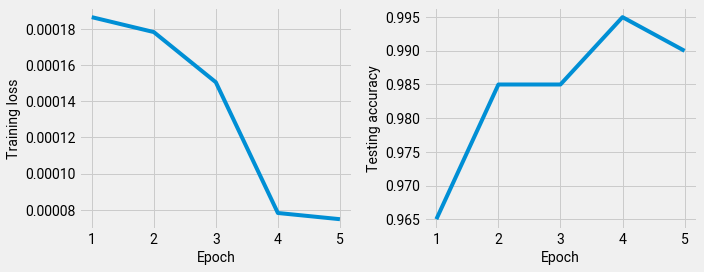

In [23]:
train_and_test(model,5,train_dataloader,test_dataloader,loss_fn,optimizer)

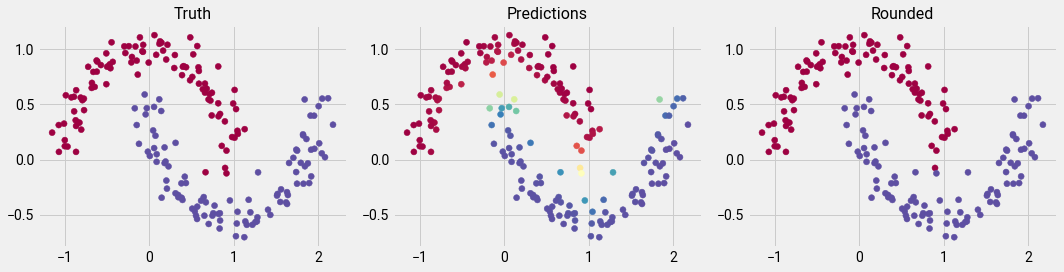

In [24]:
with torch.no_grad():
    pred = model(torch.Tensor(test_data.data))
    
fig,axes = plt.subplots(1,3,figsize=(15,4))

axes[0].scatter(test_data.data[:,0],test_data.data[:,1],c=test_data.labels,cmap="Spectral")
axes[0].set_title("Truth")
axes[1].scatter(test_data.data[:,0],test_data.data[:,1],c=pred,cmap="Spectral")
axes[1].set_title("Predictions")
axes[2].scatter(test_data.data[:,0],test_data.data[:,1],c=pred.round(),cmap="Spectral")
axes[2].set_title("Rounded")
fig.tight_layout()